In [1]:
import os
import glob

import datetime as dt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.ndimage import zoom, distance_transform_edt, generic_filter, median_filter, gaussian_filter
import cmocean.cm as cm

import numpy as np
import scipy as sp
import scipy.ndimage

%matplotlib inline

In [2]:
def fill_gaps_nn(array, distance=2, mask=None):
    """ Fill gaps in input array
    # https://stackoverflow.com/questions/5551286/filling-gaps-in-a-numpy-array/9262129#9262129
    Parameters
    ----------
    array : 2D numpy.array
        Raster with data
    distance : int
        Minimum size of gap to fill
    mask : 2D numpy.array
        Raster with True where to fill gaps
    Returns
    -------
    array : 2D numpy.array
        Raster with data with gaps filled
    """
    if mask is None:
        mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r, c = indi[:, gpi]
    array = np.array(array)
    array[gpi] = array[r, c]
    return array

In [4]:
def gaussian_filter_nan(a, sigma, truncate):
    b = a.copy()
    b[np.isnan(a)]=0
    bb = gaussian_filter(b, sigma=sigma, truncate=truncate)

    w = np.ones_like(b)
    w[np.isnan(b)] = 0
    ww = gaussian_filter(w, sigma=sigma, truncate=truncate)

    return bb / ww

In [10]:
sic_dir = '/Data/sim/data/OSISAF_ice_conc_CDR/'
sid_dir = '/Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/osisaf.met.no/reprocessed/ice/drift_lr/v1/merged/'

In [14]:
ll /Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/osisaf.met.no/reprocessed/ice/drift_lr/v1/merged/1991/01/

total 6232
-rw-r--r-- 1 antonk 197351 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101011200.nc
-rw-r--r-- 1 antonk 197467 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101021200.nc
-rw-r--r-- 1 antonk 197496 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101031200.nc
-rw-r--r-- 1 antonk 197490 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101041200.nc
-rw-r--r-- 1 antonk 197508 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101051200.nc
-rw-r--r-- 1 antonk 197552 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101061200.nc
-rw-r--r-- 1 antonk 197500 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101071200.nc
-rw-r--r-- 1 antonk 197394 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101081200.nc
-rw-r--r-- 1 antonk 197575 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101091200.nc
-rw-r--r-- 1 antonk 198015 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1p0_24h-199101101200.nc
-rw-r--r-- 1 antonk 197946 Mar 28 10:11 ice_drift_nh_ease2-750_cdr-v1

In [11]:
year = '1991'
mo = '01'
sic_files = sorted(glob.glob(f'{sic_dir}/{year}/{mo}/*nc')) [15:22]
#sic_files = sorted(glob.glob(f'{sic_dir}/{year}/{mo}/*nc')) [17:20]

sic_dates = [f.split('_')[-1].split('.')[0] for f in sic_files]
sid_files = [f for f in sorted(glob.glob(f'{sid_dir}/{year}/{mo}/*nc')) if f.split('-')[-1].split('.')[0] in sic_dates]
print(len(sid_files), sid_files[0], sid_files[-1])

7 /Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/osisaf.met.no/reprocessed/ice/drift_lr/v1/merged//1991/01/ice_drift_nh_ease2-750_cdr-v1p0_24h-199101161200.nc /Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/osisaf.met.no/reprocessed/ice/drift_lr/v1/merged//1991/01/ice_drift_nh_ease2-750_cdr-v1p0_24h-199101221200.nc


In [7]:
flag_values = np.array([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 30])
flag_conv = np.zeros(31)
flag_conv[flag_values] = np.arange(flag_values.size)


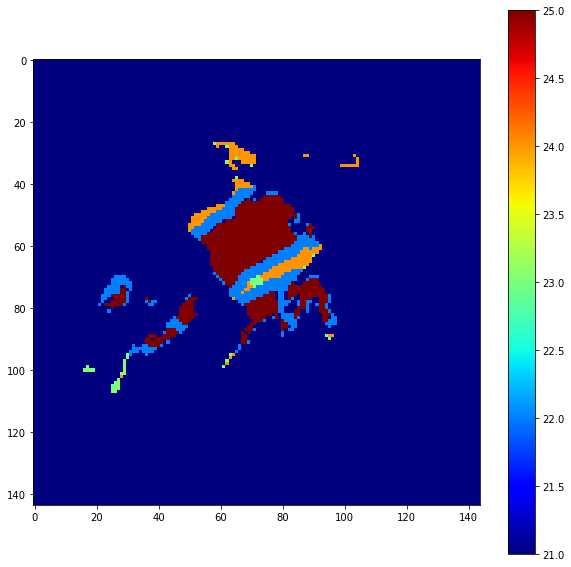

In [25]:
sid_file = '/Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/osisaf.met.no/reprocessed/ice/drift_lr/v1/merged//1991/01/ice_drift_nh_ease2-750_cdr-v1p0_24h-199101181200.nc'
dds = Dataset(sid_file) 
dflag = dds['status_flag'][0]
plt.figure(figsize=(10,10))
plt.imshow(dflag, clim=[21, 25], cmap='jet', interpolation='nearest')
plt.colorbar()

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101161200.nc


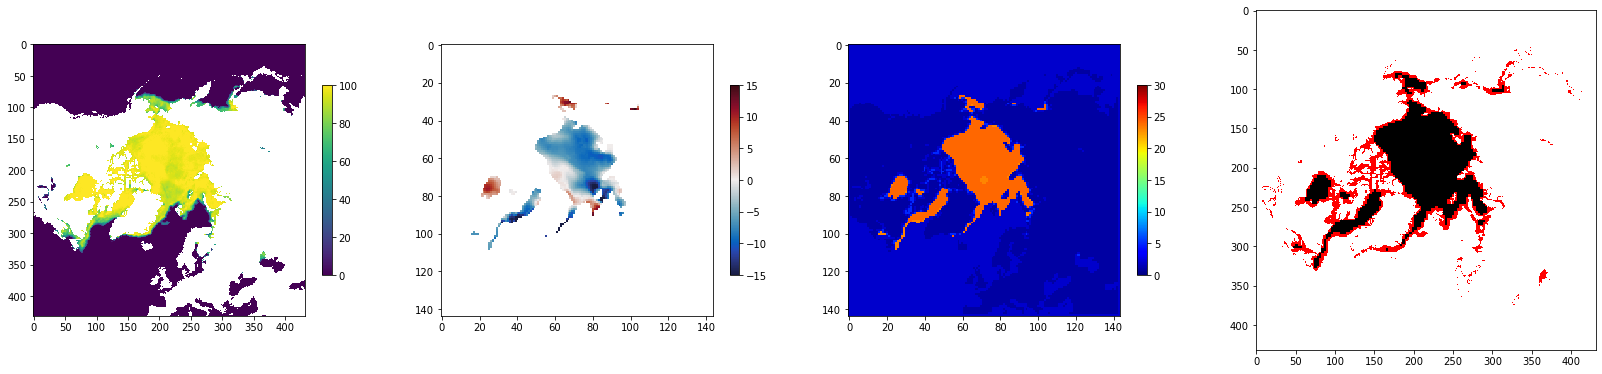

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101171200.nc


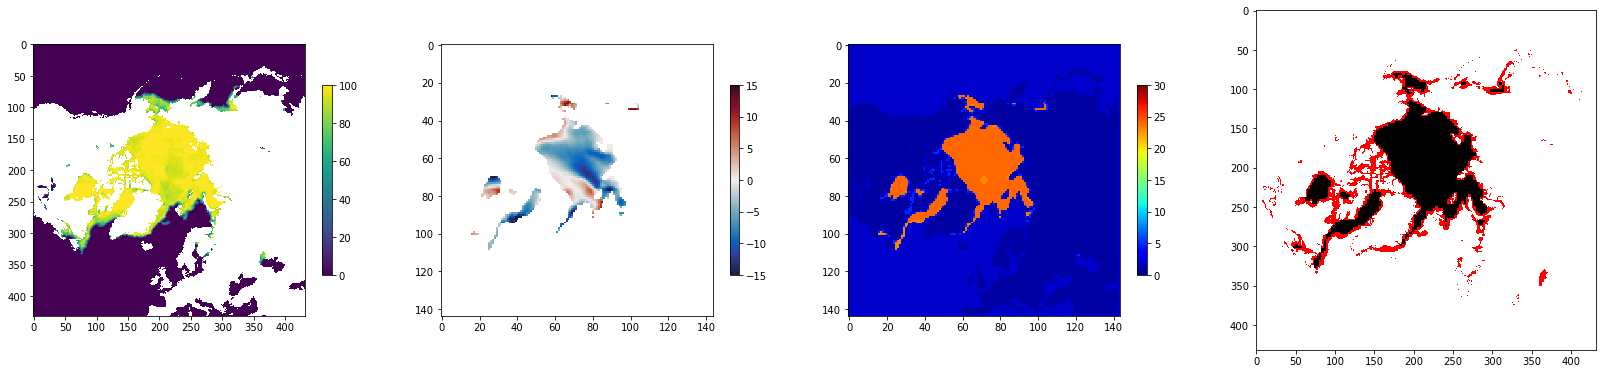

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101181200.nc


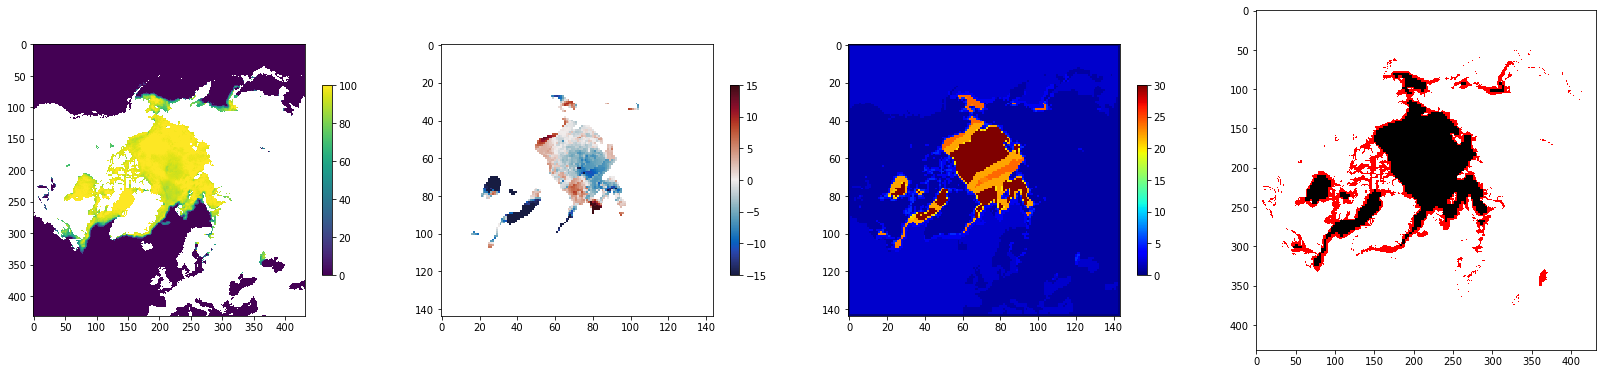

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101191200.nc


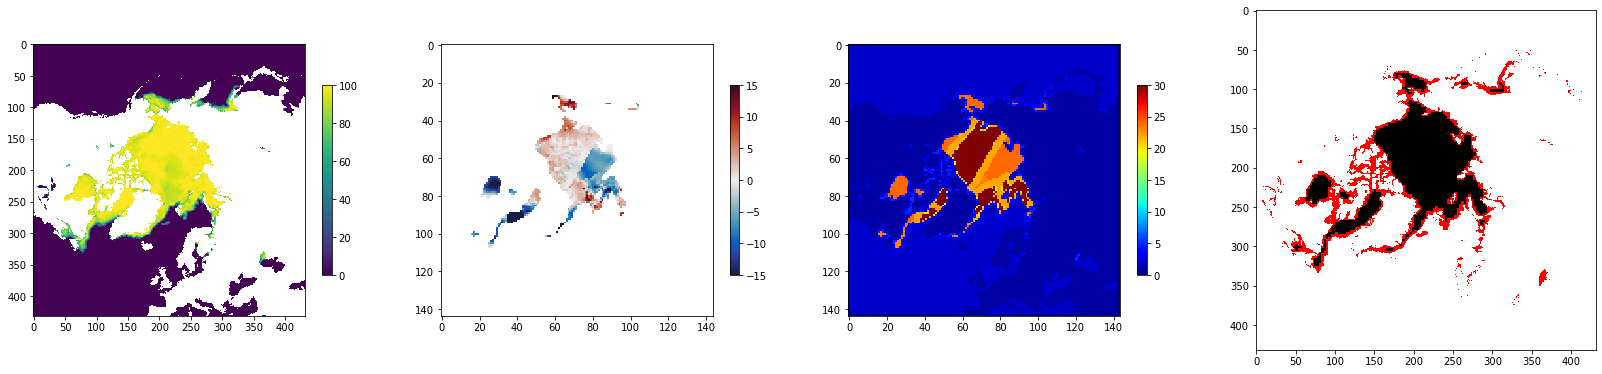

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101201200.nc


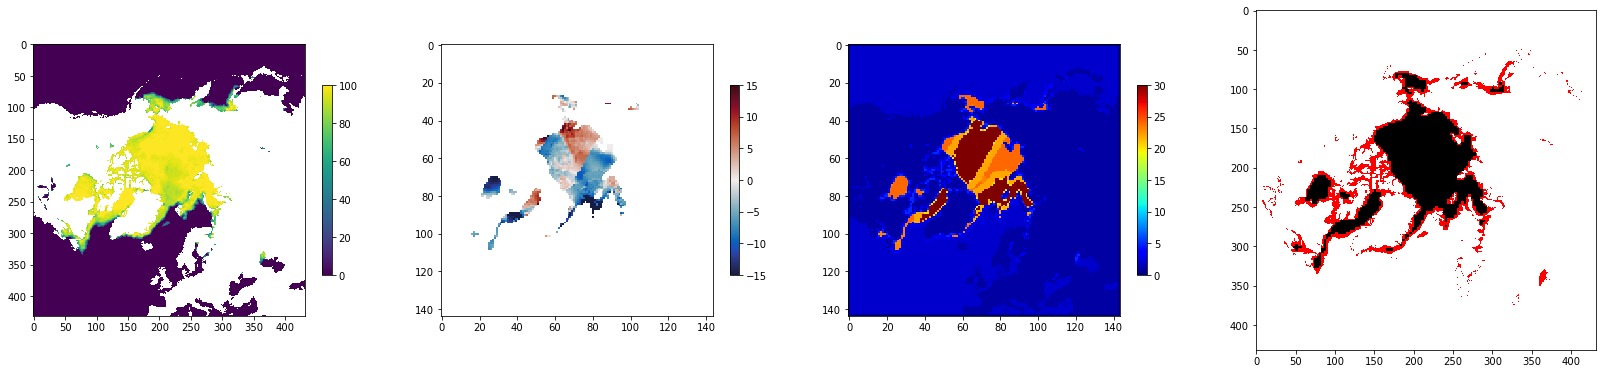

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101211200.nc


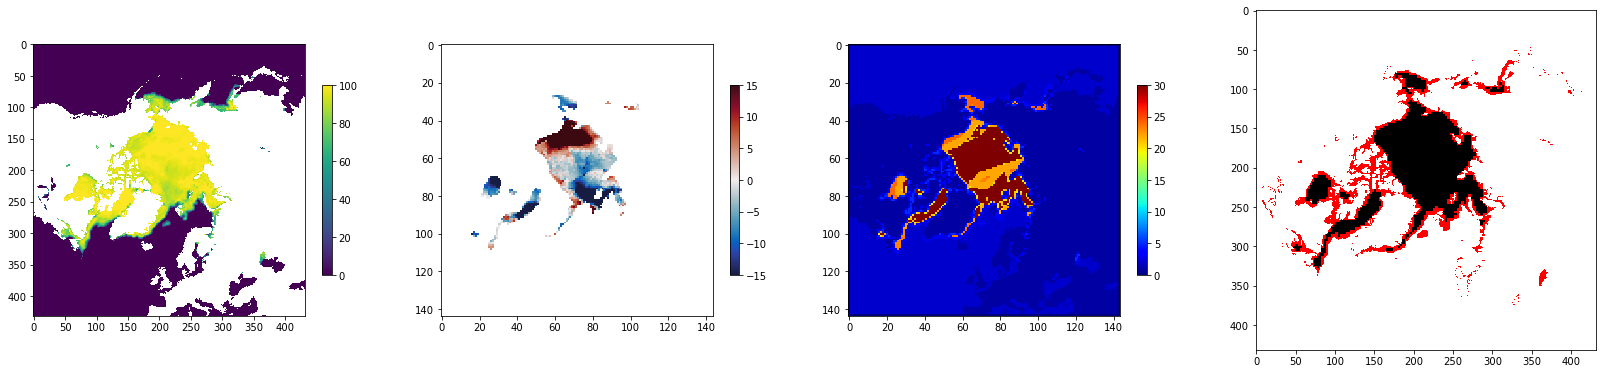

ice_drift_nh_ease2-750_cdr-v1p0_24h-199101221200.nc


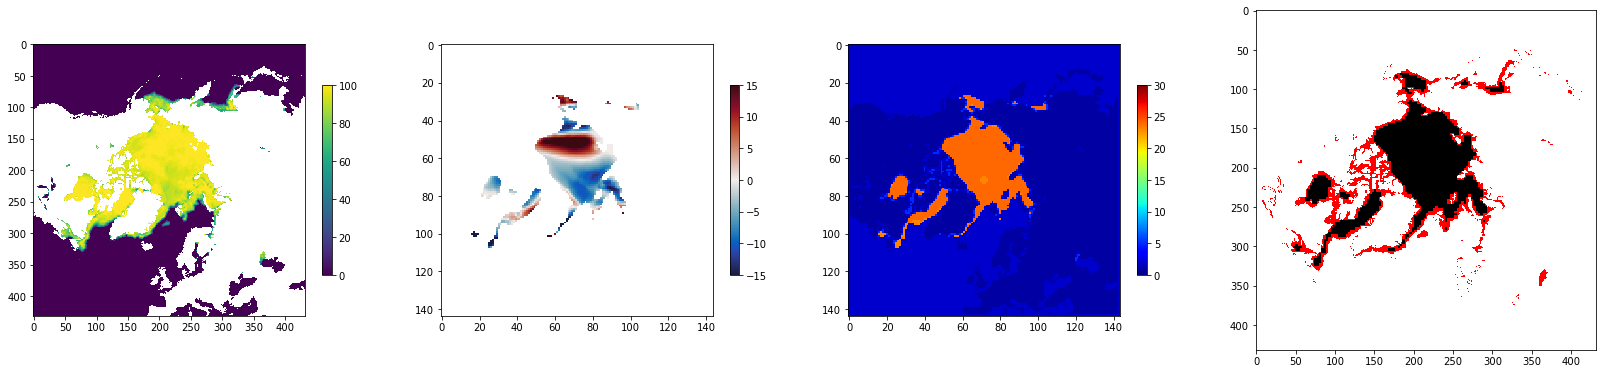

In [53]:
ddx = []
ddy = []
ddflag = []

for sic_file, sid_file in zip(sic_files, sid_files):
    print(os.path.basename(sid_file))
    cds = Dataset(sic_file)
    dds = Dataset(sid_file)
    sic = cds['ice_conc'][0].filled(np.nan)
    dx = dds['dX'][0].filled(np.nan)
    dy = -dds['dY'][0].filled(np.nan)
    dflag = dds['status_flag'][0]
    
    ddx.append(dx)
    ddy.append(dy)
    ddflag.append(dflag)

    fig, ax = plt.subplots(1,4, figsize=(28,7))
    imsh = ax[0].imshow(sic, interpolation='nearest')
    plt.colorbar(imsh, ax=ax[0], shrink=0.5)
    
    imsh = ax[1].imshow(dx, interpolation='nearest', clim=[-15, 15], cmap=cm.balance)
    plt.colorbar(imsh, ax=ax[1], shrink=0.5)

    sic_mask = (sic > 0).astype(float)
    sic_mask[sic_mask == 0] = np.nan

    imsh = ax[2].imshow(flag_conv[dflag], clim=[2, 14], cmap='jet', interpolation='nearest')
    imsh = ax[2].imshow(dflag, clim=[0, 30], cmap='jet', interpolation='nearest')
    
    plt.colorbar(imsh, ax=ax[2], shrink=0.5)
    
    ax[3].imshow(sic_mask, interpolation='nearest', clim=[0,1], cmap='bwr')
    ax[3].imshow(zoom(dx,3,order=0), interpolation='nearest', clim=[100, 110], cmap='gray')

    plt.show()


In [54]:
ddx_nan = []
ddy_nan = []
for dx,dy,dflag in zip(ddx, ddy, ddflag):
    bad_pix = (dflag == 23) + (dflag == 24) #(dflag==22) * (dx == 0) * (dy == 0)
    dx_nan = np.array(dx)
    dx_nan[bad_pix] = np.nan
    ddx_nan.append(dx_nan)
    dy_nan = np.array(dy)
    dy_nan[bad_pix] = np.nan
    ddy_nan.append(dy_nan)

dx_mean = np.nanmean(ddx_nan, axis=0)
dy_mean = np.nanmean(ddy_nan, axis=0)

ddx_mean = np.nanmean(ddx, axis=0)
ddy_mean = np.nanmean(ddy, axis=0)


/tmp/ipykernel_107828/3715252543.py:12: RuntimeWarning: Mean of empty slice
  dx_mean = np.nanmean(ddx_nan, axis=0)
/tmp/ipykernel_107828/3715252543.py:13: RuntimeWarning: Mean of empty slice
  dy_mean = np.nanmean(ddy_nan, axis=0)
/tmp/ipykernel_107828/3715252543.py:15: RuntimeWarning: Mean of empty slice
  ddx_mean = np.nanmean(ddx, axis=0)
/tmp/ipykernel_107828/3715252543.py:16: RuntimeWarning: Mean of empty slice
  ddy_mean = np.nanmean(ddy, axis=0)


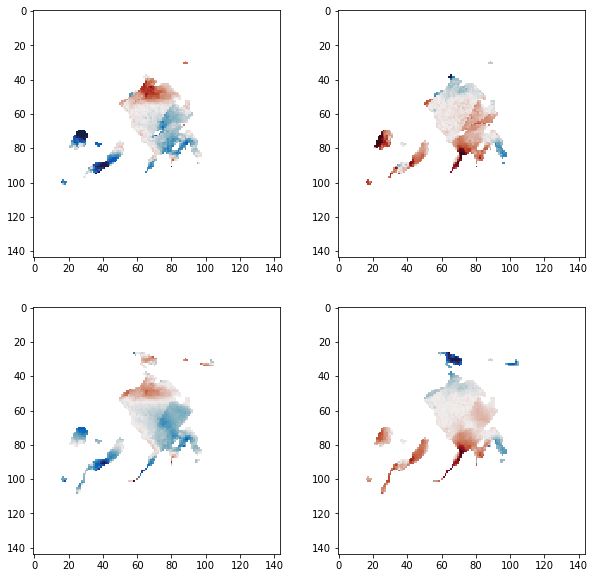

In [55]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(dx_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[0,1].imshow(dy_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1,0].imshow(ddx_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1,1].imshow(ddy_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()


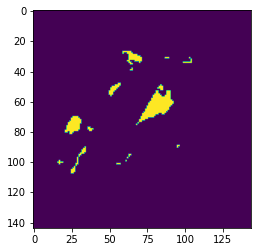

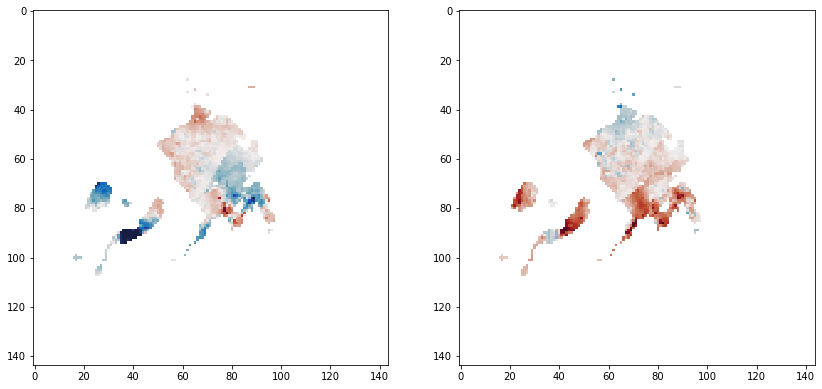

In [37]:
cds = Dataset(sic_files[3])
dds = Dataset(sid_files[3])
sic = cds['ice_conc'][0].filled(np.nan)
dx = dds['dX'][0].filled(np.nan)
dy = -dds['dY'][0].filled(np.nan)
dflag = dds['status_flag'][0]

sic_mask = (sic > 0).astype(float)
sic_mask[sic_mask == 0] = np.nan

replace_w_mean = (dflag==23) + (dflag==24)#(dflag==22) * (dx == 0) * (dy == 0)
plt.imshow(replace_w_mean)
plt.show()

dxo = np.array(dx)
dyo = np.array(dy)

dx[np.isnan(dx)] = 0
dy[np.isnan(dy)] = 0
dx[replace_w_mean] = np.nan
dy[replace_w_mean] = np.nan
dx = fill_gaps_nn(dx, 100)
dy = fill_gaps_nn(dy, 100)

dx = (dx + dx_mean) / 2
dy = (dy + dy_mean) / 2

dxo[replace_w_mean] = dx[replace_w_mean]
dyo[replace_w_mean] = dy[replace_w_mean]

fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].imshow(dxo, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1].imshow(dyo, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()

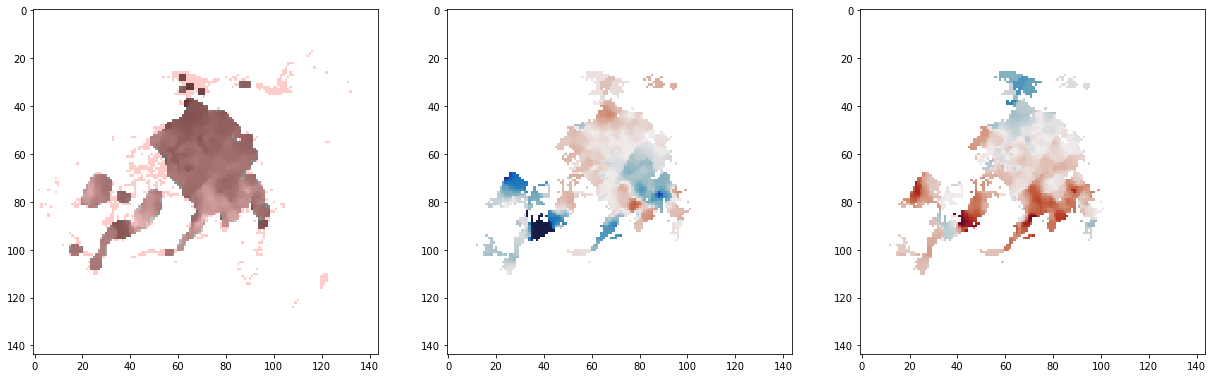

In [38]:
dxof = generic_filter(dxo, np.nanmedian, 3)
dyof = generic_filter(dyo, np.nanmedian, 3)

dxoff = fill_gaps_nn(dxof, 5)
dyoff = fill_gaps_nn(dyof, 5)

dxoff[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan
dyoff[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(dyof, interpolation='nearest', clim=[-20, 20], cmap='gray')
ax[0].imshow(sic_mask[1:-1:3, 1:-1:3], interpolation='nearest', clim=[0,1], cmap='bwr', alpha=0.2)

ax[1].imshow(dxoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[2].imshow(dyoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()


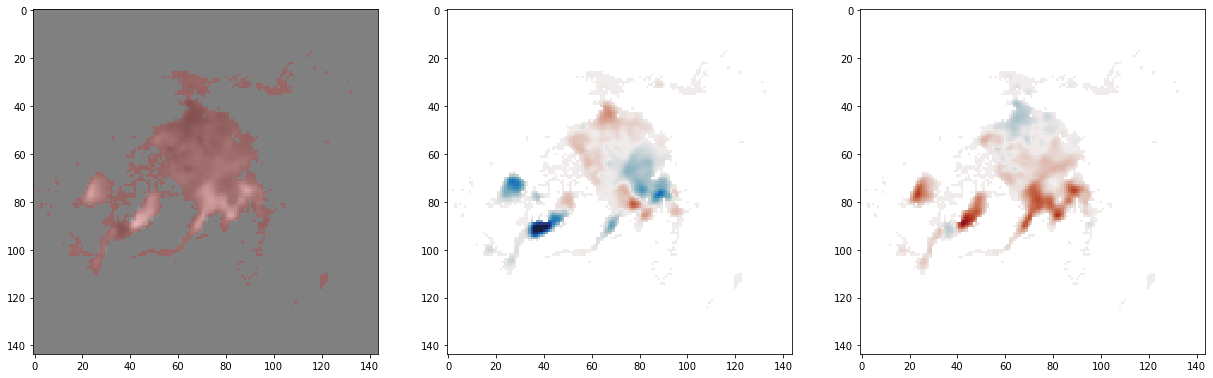

In [39]:
dxof1 = gaussian_filter_nan(dxo, 1, 2)
dyof1 = gaussian_filter_nan(dyo, 1, 2)

dxoff1 = fill_gaps_nn(dxof1, 5)
dyoff1 = fill_gaps_nn(dyof1, 5)

dxoff1[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan
dyoff1[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(dyof1, interpolation='nearest', clim=[-20, 20], cmap='gray')
ax[0].imshow(sic_mask[1:-1:3, 1:-1:3], interpolation='nearest', clim=[0,1], cmap='bwr', alpha=0.2)

ax[1].imshow(dxoff1, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[2].imshow(dyoff1, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()


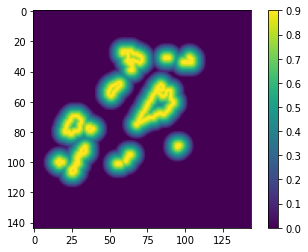

In [40]:
max_dist = 10
dist = distance_transform_edt(replace_w_mean, return_distances=True) + distance_transform_edt(~replace_w_mean, return_distances=True)
dist_weight = 1 - np.clip(dist, 0, max_dist)/max_dist
plt.imshow(dist_weight)
plt.colorbar()

In [41]:
dxw = dist_weight * dxoff1 + (1 - dist_weight) * dxoff
dyw = dist_weight * dyoff1 + (1 - dist_weight) * dyoff


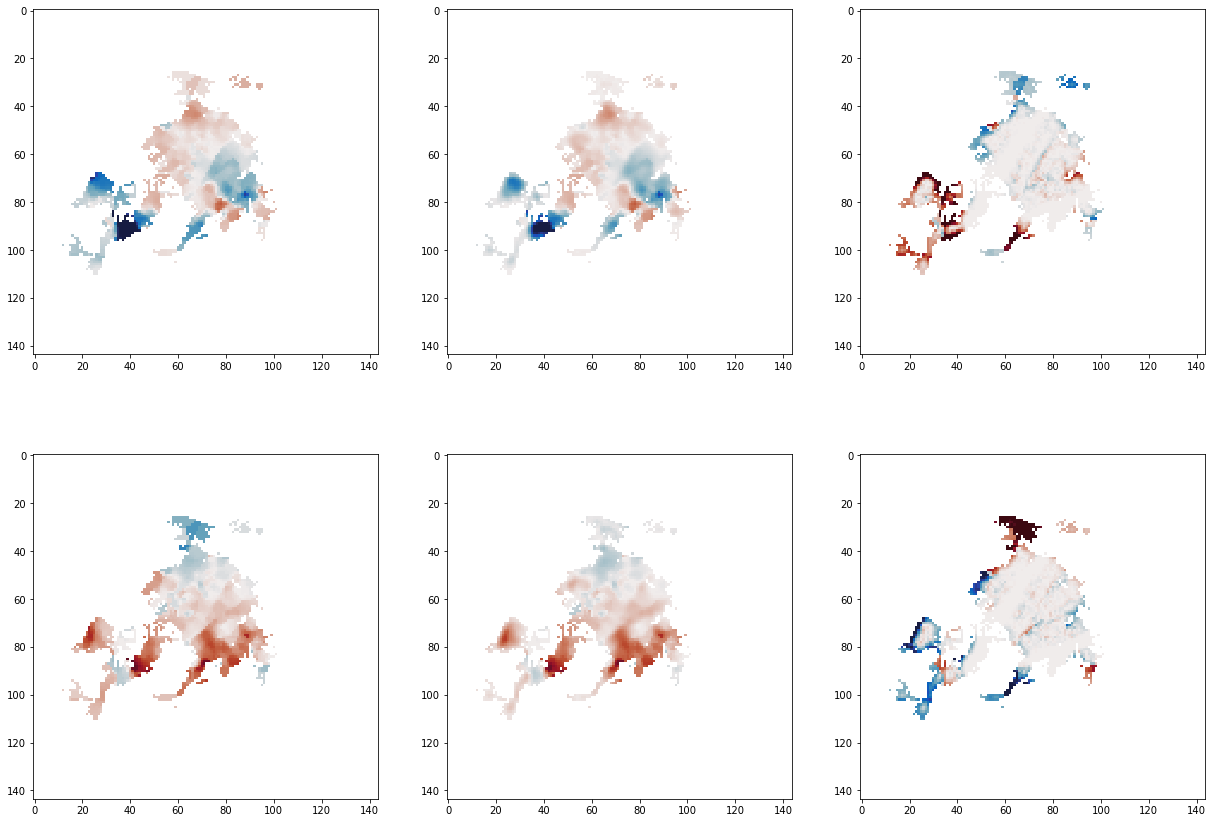

In [42]:
fig, ax = plt.subplots(2,3,figsize=(21,15))
ax[0,0].imshow(dxoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1,0].imshow(dyoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)

ax[0,1].imshow(dxw, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1,1].imshow(dyw, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)

ax[0,2].imshow(dxw-dxoff, interpolation='nearest', clim=[-5, 5], cmap=cm.balance)
ax[1,2].imshow(dyw-dyoff, interpolation='nearest', clim=[-5, 5], cmap=cm.balance)

plt.show()
